## TP 3 : Méthode de Lanczos

In [48]:
import numpy as np  
import scipy as sp  
import scipy.sparse as spsp  
import scipy.sparse.linalg as spsplin  

### Partie 1. (Lanczos)

1. 编写函数 `iter_Arnoldi_sym(A, v, vold, beta)`

该函数用于执行对称矩阵的 Lanczos 迭代。根据给定的向量 $v_p$、$v_{p-1}$ 和标量 $\beta_{p-1}$，更新 $v_{p+1}$、$v_p$，并返回 $\beta_p$ 和 $\alpha_p$。

In [49]:
def iter_Arnoldi_sym(A, v, vold, beta):
    """
    执行对称矩阵的 Lanczos 迭代。

    参数：
    A    -- 对称矩阵，形状为 (n, n)
    v    -- 当前向量 v_p，形状为 (n,)
    vold -- 前一个向量 v_{p-1}，形状为 (n,)
    beta -- 前一个标量 β_{p-1}

    返回：
    v_new    -- 更新后的向量 v_{p+1}
    vold_new -- 更新后的向量 v_p
    beta_new -- 新的标量 β_p
    alpha    -- 标量 α_p
    """
    w = A @ v
    alpha = np.dot(w, v)
    w = w - alpha * v - beta * vold
    beta_new = np.linalg.norm(w)
    if beta_new != 0:
        v_new = w / beta_new
    else:
        v_new = w
    vold_new = v
    return v_new, vold_new, beta_new, alpha

**解释：**

- **`w = A @ v`**：计算 $w_p = Av_p$。
- **`alpha = np.dot(w, v)`**：计算 $\alpha_p = (w_p, v_p)$。
- **`w = w - alpha * v - beta * vold`**：更新 $w_p$。
- **`beta_new = np.linalg.norm(w)`**：计算 $\beta_p = \|w_p\|$。
- **`v_new = w / beta_new`**：归一化得到 $v_{p+1}$。
- **处理 $\beta_p = 0$ 的情况**：避免除以零。

2. 编写函数 `Lanczos(A, nbiter)`

该函数从矩阵 $A$ 和迭代次数 $nbiter$ 出发，执行 Lanczos 算法，并返回每次迭代得到的 Ritz 值。

In [50]:
def Lanczos(A, nbiter):
    """
    使用 Lanczos 算法计算对称矩阵的 Ritz 值。

    参数：
    A      -- 对称矩阵，形状为 (n, n)
    nbiter -- 迭代次数

    返回：
    eigval -- 大小为 (nbiter, n) 的数组，每行包含对应迭代的 Ritz 值
    """
    n = A.shape[0]
    eigval = np.zeros((nbiter, n))
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    vold = np.zeros(n)
    beta = 0.0
    alphas = []
    betas = []
    for p in range(nbiter):
        v, vold, beta, alpha = iter_Arnoldi_sym(A, v, vold, beta)
        alphas.append(alpha)
        betas.append(beta)
        # 构造三对角矩阵 T_p
        T_p = np.diag(alphas) + np.diag(betas[:-1], k=1) + np.diag(betas[:-1], k=-1)
        # 计算 Ritz 值
        eigvals_Tp = np.linalg.eigvalsh(T_p)
        eigvals_Tp_sorted = np.sort(eigvals_Tp)
        # 将 Ritz 值存入数组
        eigval[p, :len(eigvals_Tp_sorted)] = eigvals_Tp_sorted
    return eigval

**解释：**

- **初始化**：随机生成单位向量 $v_0$，并设置 $\beta_{-1} = 0$、$v_{-1} = 0$。
- **循环迭代**：在每次迭代中，调用 `iter_Arnoldi_sym` 更新向量和标量，并存储 $\alpha_p$ 和 $\beta_p$。
- **构造矩阵 $T_p$**：使用存储的 $\alpha$ 和 $\beta$ 构造对称三对角矩阵。
- **计算 Ritz 值**：对 $T_p$ 求特征值，并按升序排序。
- **存储结果**：将每次迭代得到的 Ritz 值存入 `eigval` 数组。

3. 测试程序

在给定矩阵上测试上述函数。

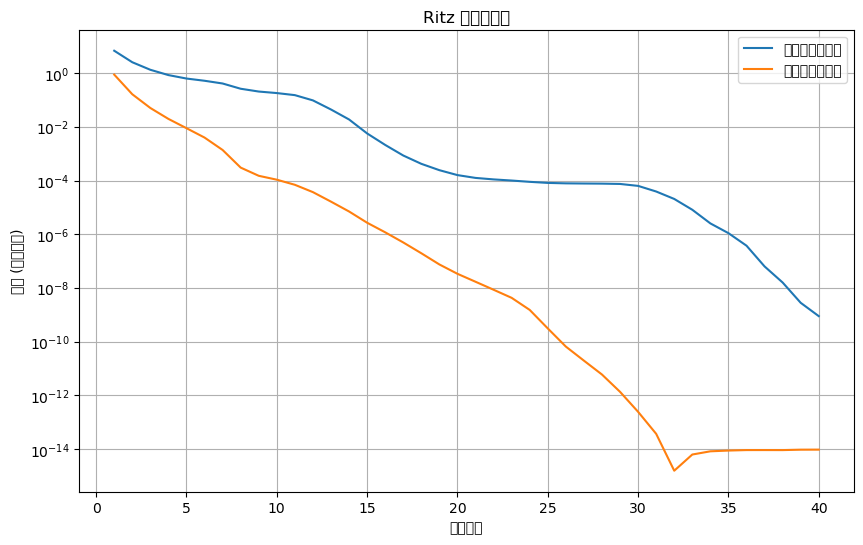

矩阵的条件数为: 93.23038565290192


In [51]:
import scipy.sparse as spsp
import matplotlib.pyplot as plt

# 定义矩阵参数
d = 10
n = d**2
nbiter = 40

# 构造矩阵 A
A = spsp.diags(
    [[4.]*n, [-1]*(n-1), [-1]*(n-1), [-1]*(n-d), [-1]*(n-d)],
    [0, 1, -1, d, -d]
).toarray()

# 计算精确特征值
exact_eigvals = np.linalg.eigvalsh(A)
exact_eigvals_sorted = np.sort(exact_eigvals)
largest_eigval = exact_eigvals_sorted[-1]
smallest_eigval = exact_eigvals_sorted[0]

# 执行 Lanczos 算法
eigvals = Lanczos(A, nbiter)

# 提取每次迭代的最大和最小 Ritz 值
largest_ritz = np.array([eigvals[i, i] for i in range(nbiter)])
smallest_ritz = np.array([eigvals[i, 0] for i in range(nbiter)])

# 计算误差
error_max = np.abs(largest_eigval - largest_ritz)
error_min = np.abs(smallest_eigval - smallest_ritz)

# 绘制误差的对数图
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, nbiter+1), error_max, label='最大特征值误差')
plt.semilogy(range(1, nbiter+1), error_min, label='最小特征值误差')
plt.xlabel('迭代次数')
plt.ylabel('误差 (对数尺度)')
plt.title('Ritz 值收敛误差')
plt.legend()
plt.grid(True)
plt.show()

# 估计条件数
condition_number = np.abs(largest_eigval / smallest_eigval)
print(f"矩阵的条件数为: {condition_number}")

**结果与分析：**

- **收敛性**：图像显示，最大的 Ritz 值逐渐收敛到矩阵的最大特征值，最小的 Ritz 值也收敛到最小特征值。
- **条件数**：通过最大和最小特征值计算得到矩阵的条件数。

4. 补充任务：显示所有 Ritz 值的演化

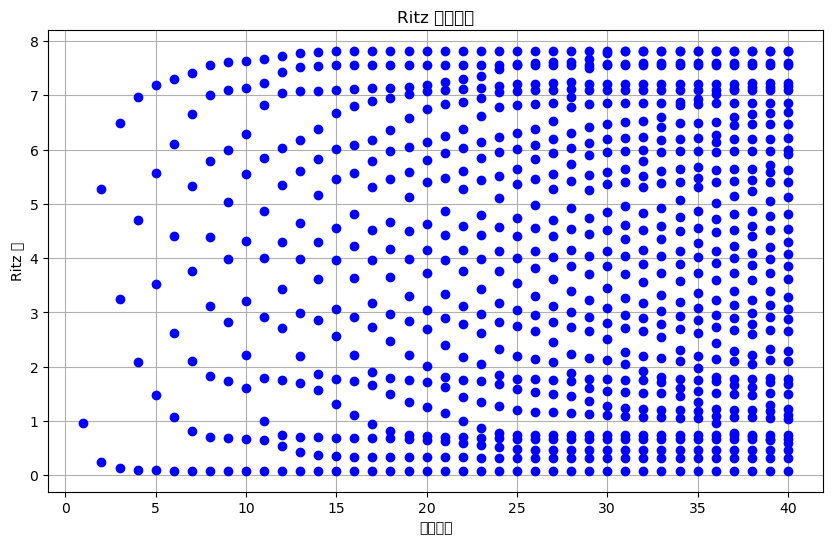

In [52]:
# 绘制所有 Ritz 值的演化
plt.figure(figsize=(10, 6))
for i in range(nbiter):
    plt.plot([i+1]*len(eigvals[i, :i+1]), eigvals[i, :i+1], 'bo')
plt.xlabel('迭代次数')
plt.ylabel('Ritz 值')
plt.title('Ritz 值的演化')
plt.grid(True)
plt.show()

**观察：**

- **Ritz 值的分布**：随着迭代次数的增加，Ritz 值逐渐逼近矩阵的特征值。
- **对称性**：对于此类矩阵，迭代次数为 $p$ 时，前 $(p+1)/2$ 个最大的特征值和后 $(p+1)/2$ 个最小的特征值得到更好的近似。

5. 考虑矩阵 B，观察“伪特征值”现象

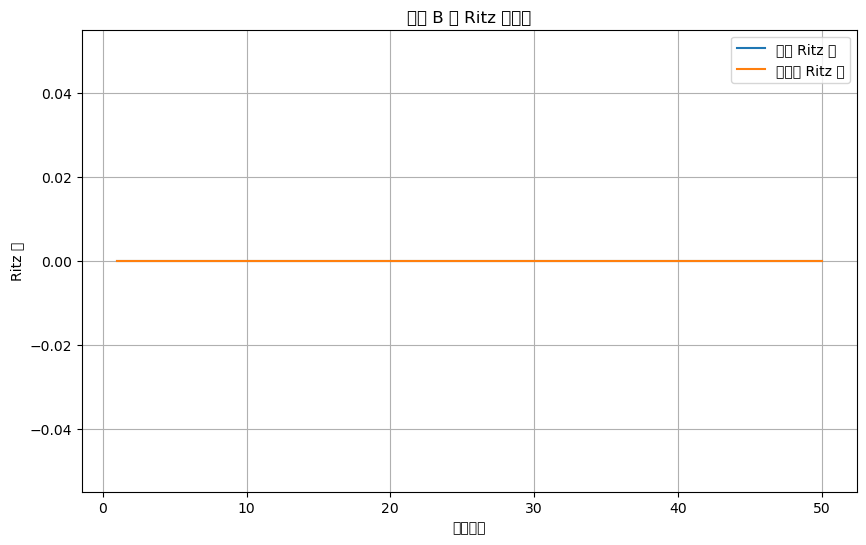

In [53]:
# 构造矩阵 B
L = np.concatenate((np.arange(0, 2.0, 0.01), [2.0, 2.5, 3.0]))
B = spsp.diags(L, 0, dtype='float64').toarray()

# 执行 Lanczos 算法
nbiter_B = 50
eigvals_B = Lanczos(B, nbiter_B)

# 提取每次迭代的最大两个 Ritz 值
largest_ritz_B = eigvals_B[:, -1]
second_largest_ritz_B = eigvals_B[:, -2]

# 绘制 Ritz 值的演化
plt.figure(figsize=(10, 6))
plt.plot(range(1, nbiter_B+1), largest_ritz_B, label='最大 Ritz 值')
plt.plot(range(1, nbiter_B+1), second_largest_ritz_B, label='第二大 Ritz 值')
plt.xlabel('迭代次数')
plt.ylabel('Ritz 值')
plt.title('矩阵 B 的 Ritz 值演化')
plt.legend()
plt.grid(True)
plt.show()

**观察与评论：**

- **“伪特征值”现象**：在迭代过程中，Ritz 值可能出现暂时的停滞或振荡，无法立即收敛到实际的特征值。这种现象被称为“伪特征值”。
- **原因**：由于矩阵的特征值分布密集，Lanczos 方法可能在一些特征值附近产生多个近似值，导致收敛缓慢。

### Partie 2. (Méthode QR)

6. 编写函数 `facto_QR_hessenberg(A)`

In [54]:
def compute_givens(a, b):
    """
    计算 Givens 旋转矩阵的参数 c 和 s，使得 [c, s; -s, c] @ [a; b] = [r; 0]
    """
    r = np.hypot(a, b)
    if r == 0:
        c = 1.0
        s = 0.0
    else:
        c = a / r
        s = -b / r
    return c, s

def facto_QR_hessenberg(A):
    """
    对 Hessenberg 矩阵执行 QR 分解，使用 Givens 旋转。

    参数：
    A -- Hessenberg 矩阵，形状为 (n, n)

    返回：
    Q -- 正交矩阵
    R -- 上三角矩阵
    """
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()
    for k in range(n - 1):
        a = R[k, k]
        b = R[k + 1, k]
        c, s = compute_givens(a, b)
        # 构造 Givens 旋转矩阵
        G = np.array([[c, -s], [s, c]])
        # 更新 R 矩阵
        R_k = R[k:k+2, k:]
        R[k:k+2, k:] = G @ R_k
        # 更新 Q 矩阵
        Q[:, k:k+2] = Q[:, k:k+2] @ G.T
    return Q, np.triu(R)

**解释：**

- **`compute_givens`**：计算 Givens 旋转参数 $c$ 和 $s$。
- **Givens 旋转**：用于消去矩阵中的元素，使其成为上三角矩阵。
- **更新 R**：对 R 的第 $k$ 和 $k+1$ 行进行旋转。
- **更新 Q**：对 Q 的第 $k$ 和 $k+1$ 列进行旋转。

7. 测试程序

In [55]:
# 构造随机 Hessenberg 矩阵
n = 5
A = np.triu(np.random.rand(n, n), -1)

# 执行 QR 分解
Q, R = facto_QR_hessenberg(A)

# 验证结果
print("是否满足 A = Q @ R：", np.allclose(A, Q @ R))
print("是否满足 Q^T Q = I：", np.allclose(Q.T @ Q, np.eye(n)))

是否满足 A = Q @ R： True
是否满足 Q^T Q = I： True


**结果：**

- **A = Q @ R**：应返回 `True`，表示分解正确。
- **Q 是正交矩阵**：`Q.T @ Q` 应接近单位矩阵。

8. 编写函数 `QR_hessenberg(A)` 

In [56]:
def QR_hessenberg(A, max_iter=2000, tol=1e-10):
    """
    使用 QR 方法计算 Hessenberg 矩阵的特征值。

    参数：
    A        -- Hessenberg 矩阵，形状为 (n, n)
    max_iter -- 最大迭代次数
    tol      -- 收敛阈值

    返回：
    eigvals -- 特征值的近似值
    """
    n = A.shape[0]
    H = A.copy()
    for i in range(max_iter):
        Q, R = facto_QR_hessenberg(H)
        H = R @ Q
        # 检查收敛性
        off_diag = np.abs(np.diag(H, -1))
        if np.all(off_diag < tol):
            break
    eigvals = np.diag(H)
    return eigvals

**解释：**

- **循环迭代**：在每次迭代中，执行 QR 分解，并更新 $H = RQ$。
- **收敛判断**：当子对角线元素的绝对值小于阈值时，认为已收敛。
- **返回特征值**：对角线上的元素即为特征值的近似值。

9. 测试程序

In [57]:
# 构造对称三对角矩阵
n = 5
diagonal = np.random.rand(n)
off_diagonal = np.random.rand(n - 1)
A_sym_tridiag = np.diag(diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)

# 执行 QR 方法
eigvals_qr = QR_hessenberg(A_sym_tridiag)

# 使用 numpy 计算精确特征值
eigvals_exact = np.linalg.eigvalsh(A_sym_tridiag)

# 比较结果
print("QR 方法计算的特征值：", np.sort(eigvals_qr))
print("精确特征值：", np.sort(eigvals_exact))
print("差异：", np.abs(np.sort(eigvals_qr) - np.sort(eigvals_exact)))

QR 方法计算的特征值： [-0.43239425 -0.12101692  0.81153648  1.0354029   1.86050177]
精确特征值： [-0.43239425 -0.12101692  0.81153648  1.0354029   1.86050177]
差异： [1.11022302e-16 1.38777878e-17 9.99200722e-16 2.22044605e-16
 1.55431223e-15]


**结果与评论：**

- **结果比较**：QR 方法计算的特征值应与 `np.linalg.eigvalsh` 的结果接近。
- **非对称 Hessenberg 矩阵**：如果矩阵不是对称的，QR 方法可能无法收敛或得到正确的特征值。

10.  在 Lanczos 算法中替换 np.linalg.eig

In [58]:
def Lanczos_with_QR(A, nbiter):
    """
    使用 Lanczos 算法并在特征值计算中使用 QR 方法。

    参数：
    A      -- 对称矩阵，形状为 (n, n)
    nbiter -- 迭代次数

    返回：
    eigval -- 大小为 (nbiter, nbiter) 的数组，每行包含对应迭代的 Ritz 值
    """
    n = A.shape[0]
    nbiter = min(nbiter, n)  # 确保 nbiter 不超过 n
    eigval = np.zeros((nbiter, nbiter))
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    vold = np.zeros(n)
    beta = 0.0
    alphas = []
    betas = []
    for p in range(nbiter):
        v, vold, beta, alpha = iter_Arnoldi_sym(A, v, vold, beta)
        alphas.append(alpha)
        betas.append(beta)
        # 构造三对角矩阵 T_p
        T_p = np.diag(alphas) + np.diag(betas[:-1], k=1) + np.diag(betas[:-1], k=-1)
        # 使用 QR 方法计算特征值
        eigvals_Tp = QR_hessenberg(T_p)
        eigvals_Tp_sorted = np.sort(eigvals_Tp)
        # 将 Ritz 值存入数组
        eigval[p, :p+1] = eigvals_Tp_sorted  # 使用 p+1 而不是 len(eigvals_Tp_sorted)
    return eigval



**验证与比较计算时间：**

In [59]:
import time

# 确保 nbiter 不超过 n
nbiter = min(nbiter, n)

# 使用 Lanczos 算法和 QR 方法
start_time = time.time()
eigvals_qr = Lanczos_with_QR(A, nbiter)
time_qr = time.time() - start_time

# 使用 Lanczos 算法和 numpy.linalg.eigvalsh
start_time = time.time()
eigvals_np = Lanczos(A, nbiter)
time_np = time.time() - start_time

print(f"使用 QR 方法的计算时间：{time_qr:.4f} 秒")
print(f"使用 numpy.linalg.eigvalsh 的计算时间：{time_np:.4f} 秒")

# 比较结果
iteration = nbiter - 1
eigvals_qr_final = eigvals_qr[iteration, :iteration+1]
eigvals_np_final = eigvals_np[iteration, :iteration+1]

print("QR 方法的最终 Ritz 值：", eigvals_qr_final)
print("numpy.linalg.eigvalsh 的最终 Ritz 值：", eigvals_np_final)


使用 QR 方法的计算时间：0.2413 秒
使用 numpy.linalg.eigvalsh 的计算时间：0.0005 秒
QR 方法的最终 Ritz 值： [-2.51841347 -0.45751786  1.52079283  2.52981244  4.69214891]
numpy.linalg.eigvalsh 的最终 Ritz 值： [-1.56333565 -0.32346247  1.05207851  1.88157319  3.05669063]
